In [16]:
import time
import os
import io
from tqdm import tqdm
from qqdm import qqdm, format_str
import pandas as pd
import numpy as np
import random
import pickle
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models

import transformers
from datasets import load_dataset, load_from_disk
from transformers import AutoModel, AutoConfig, AutoTokenizer
from transformers import AdamW

import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_curve,
    auc
)
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

# 忽略红色提示
import warnings
warnings.filterwarnings("ignore")

In [2]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(7890)

In [3]:
# 从预训练模型加载分词器
tokenizer = AutoTokenizer.from_pretrained('../model/hfl_rbt6')  # 可以考虑换成'bert-base-chinese'，建议下载到本地使用

# 设置设备为GPU如果可用，否则使用CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
class MultimodalDataset(Dataset):
    def __init__(self, data_file):
        # 打开数据文件并加载数据
        with open(data_file, 'rb') as f:
            self.data = pickle.load(f)
        # 定义图像的预处理步骤
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 调整图片大小以匹配模型输入
            transforms.ToTensor(),  # 将图片转换为PyTorch张量
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 对图像进行归一化
        ])

    # 返回数据集的大小
    def __len__(self):
        return len(self.data)

    # 获取数据集中的一个样本
    def __getitem__(self, idx):
        # 获取文本、图像和标签
        text = [i for i in self.data[idx]["text"]]
        images = self.data[idx]["img"]
        label = self.data[idx]["label"]

        # 如果有图像，则打开第一张图像，否则创建一个全黑的图像
        if len(images) > 0:
            image = Image.open(io.BytesIO(images[0]))
        else:
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        # 对图像进行预处理
        if self.transform:
            image = self.transform(image)

        # 返回文本、图像和标签
        return text, image, label

# 创建一个数据集实例
dataset = MultimodalDataset('train.pkl')

# 获取数据集中的第六个样本的tokens和labels
tokens, _, labels = dataset[5]
# 打印数据集的大小、第六个样本的tokens和labels
len(dataset), tokens, labels

(7531,
 ['不',
  '要',
  '再',
  '随',
  '便',
  '买',
  '奶',
  '制',
  '品',
  '给',
  '孩',
  '子',
  '喝',
  '了',
  '❗',
  '️',
  '幼',
  '儿',
  '园',
  '都',
  '发',
  '通',
  '知',
  '了',
  '家',
  '长',
  '们',
  '注',
  '意',
  '：',
  '现',
  '在',
  '得',
  '白',
  '血',
  '病',
  '的',
  '小',
  '孩',
  '越',
  '来',
  '越',
  '多',
  '，',
  '妇',
  '幼',
  '保',
  '健',
  '院',
  '提',
  '示',
  '您',
  '，',
  '请',
  '不',
  '要',
  '给',
  '宝',
  '宝',
  '喝',
  '爽',
  '歪',
  '歪',
  '和',
  '有',
  '添',
  '加',
  '剂',
  '的',
  '牛',
  '奶',
  '饮',
  '料',
  '，',
  '告',
  '诉',
  '家',
  '里',
  '有',
  '小',
  '孩',
  '的',
  '朋',
  '友',
  '，',
  '旺',
  '仔',
  '牛',
  '奶',
  '、',
  '可',
  '口',
  '可',
  '乐',
  '、',
  '爽',
  '歪',
  '歪',
  '、',
  '娃',
  '哈',
  '哈',
  'A',
  'D',
  '钙',
  '奶',
  '、',
  '未',
  '来',
  '星',
  '、',
  'Q',
  'Q',
  '星',
  '、',
  '美',
  '汁',
  '源',
  '果',
  '粒',
  '奶',
  '优',
  '菠',
  '萝',
  '味',
  '的',
  '。',
  '都',
  '含',
  '有',
  '肉',
  '毒',
  '杆',
  '菌',
  '。',
  '现',
  '在',
  '紧',
  '急',
  '召',
  '回',
  '。']

In [5]:
# 定义collate_fn函数，用于在数据加载过程中对批次数据进行处理
def collate_fn(batch):
    batch_texts = []  # 创建一个列表用于存储批次中的文本数据
    batch_images = []  # 创建一个列表用于存储批次中的图像数据
    batch_labels = []  # 创建一个列表用于存储批次中的标签数据

    # 遍历批次中的每个样本
    for item in batch:
        batch_texts.append(item[0])  # 添加文本数据到batch_texts
        batch_images.append(item[1].unsqueeze(0))  # 添加图像数据到batch_images，并增加一个维度
        batch_labels.append(item[2])  # 添加标签数据到batch_labels

    # 使用tokenizer对文本数据进行预处理
    batch_texts = tokenizer.batch_encode_plus(batch_texts,
                                              truncation=True,
                                              padding=True,
                                              return_tensors='pt',
                                              is_split_into_words=True,
                                              max_length=512-2
                                             )
    # 将图像数据列表转换为一个批次的张量，并移除多余的维度
    batch_images = torch.stack(batch_images).squeeze(1)

    # 将标签数据转换为张量
    batch_labels = torch.tensor(batch_labels)

    # 将处理后的文本、图像和标签数据转移到指定的设备上（GPU或CPU）
    return batch_texts.to(device), batch_images.to(device), batch_labels.to(device)

# def collate_fn(batch):
#     batch_texts = []
#     batch_images = []
#     batch_labels = []
#     for item in batch:
#         batch_texts.append(item[0])
#         batch_images.append(item[1]) # 将每个样本的图片作为一个列表添加
#         batch_labels.append(item[2])
#     # 对文字进行预处理
#     batch_texts = tokenizer.batch_encode_plus(batch_texts,
#                                          truncation=True,
#                                          padding=True,
#                                          return_tensors='pt',
#                                          is_split_into_words=True)
#     # 标签
#     batch_labels = torch.tensor(batch_labels)
#     # 不在这里转换图像数据为张量，在模型的forward方法中处理
#     return batch_texts.to(device), batch_images, batch_labels.to(device)

loader = DataLoader(dataset=dataset,
                    batch_size=16,  # 指定批次大小
                    collate_fn=collate_fn,  # 指定collate_fn函数
                    shuffle=True,  # 数据打乱
                    drop_last=True)  # 如果最后一个批次不足batch_size，则丢弃

# 遍历数据加载器，打印每个批次的数据
i = 0
for data in loader:
    print(data)  # 打印批次数据
    i += 1
    if i == 1:  # 如果已经遍历了一个批次，则停止
        break

({'input_ids': tensor([[ 101, 1453, 3314,  ...,    0,    0,    0],
        [ 101, 1333,  889,  ...,    0,    0,    0],
        [ 101,  523, 5401,  ...,    0,    0,    0],
        ...,
        [ 101,  523,  700,  ...,    0,    0,    0],
        [ 101, 7028, 2412,  ...,    0,    0,    0],
        [ 101,  108, 1921,  ...,    0,    0,    0]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}, tensor([[[[ 0.1768,  0.0741,  0.0398,  ...,  2.2489,  2.2489,  2.2489],
          [ 0.2282,  0.1254, -0.0116,  ...,  2.2489,  2.2489

In [6]:
class MultimodalClassifier(nn.Module):
    def __init__(self, text_model_path, img_model_path):
        super(MultimodalClassifier, self).__init__()
        # 加载预训练的文本模型
        self.text_model = AutoModel.from_pretrained(text_model_path)
        # 加载预训练的图像模型ResNet50
        self.img_model = models.resnet50(pretrained=img_model_path)
        # 将图像模型的最后一层（全连接层）替换为一个Identity层，这样就不会改变特征的维度
        self.img_model.fc = nn.Identity()
        # 设置图像模型的特征维度为2048，这是ResNet50的标准输出维度
        img_model_dim = 2048

        # 从预训练的文本模型配置中获取隐藏层的大小
        config = AutoConfig.from_pretrained(text_model_path)

        # 计算Transformer的输入维度，它是文本特征和图像特征维度的总和
        transformer_dim = config.hidden_size + img_model_dim
        
        # 定义一个Transformer编码器，用于处理融合后的文本和图像特征
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=transformer_dim,  # 设置特征维度
                nhead=8,  # 设置多头注意力的头数
                dim_feedforward=2048,  # 前馈网络的维度
                dropout=0.1  # 设置dropout比率
            ),
            num_layers=6  # 设置Transformer编码器层的数量
        )
        
        # 定义一个分类头，它包含线性层和激活函数，用于最终的分类任务
        self.classifier = nn.Sequential(
            nn.Linear(transformer_dim, 512),  # 第一个线性层
            nn.ReLU(),  # 激活函数
            nn.Linear(512, 2),  # 第二个线性层，输出维度为2，对应两个分类标签
            nn.Softmax(dim=1)  # Softmax函数，用于计算分类概率
        )

    # 定义前向传播过程
    def forward(self, input_ids, attention_mask, images):
        # 提取文本特征，特别是CLS标记的特征，它通常用于分类任务
        text_features = self.text_model(input_ids=input_ids, attention_mask=attention_mask)[0]
        text_features = text_features[:, 0, :]  # 取出CLS标记的特征

        # 提取图像特征
        img_features = self.img_model(images)

        # 将文本特征和图像特征进行融合
        combined_features = torch.cat((text_features, img_features), dim=1).unsqueeze(0)

        # 将融合后的特征通过Transformer编码器层
        transformer_output = self.transformer_encoder(combined_features)

        # 使用分类头对特征进行分类
        logits = self.classifier(transformer_output.squeeze(0))

        # 返回分类结果
        return logits

In [7]:
num_epochs = 50
best_loss = 99
model_path = "..\model"
model = MultimodalClassifier('../model/hfl_rbt6', True).to(device)

criterion = nn.CrossEntropyLoss() # 交叉熵损失
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [8]:
test_dataset = MultimodalDataset("test.pkl")
test_loader = DataLoader(dataset=test_dataset,
                batch_size=16,
                collate_fn=collate_fn,
                shuffle=True,
                drop_last=True)  # 如果最后一个批次不足batch_size，则丢弃

In [ ]:
# # 设置模型为训练模式
# model.train()
# # 初始化qqdm进度条，用于显示训练进度
# qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
# for epoch in qqdm_train:  # 遍历每一个训练周期
#     tot_loss = list()  # 创建一个列表用于存储每个批次的损失
#     for batch in loader:  # 遍历数据加载器中的每个批次
#         batch_texts, batch_images, batch_labels = batch  # 获取批次中的文本、图像和标签
#         optimizer.zero_grad()  # 清除之前的梯度
#         outputs = model(batch_texts['input_ids'], batch_texts['attention_mask'], batch_images)  # 计算模型的输出
#         loss = criterion(outputs, batch_labels)  # 计算损失
#         tot_loss.append(loss.item())  # 将损失添加到列表中
#         loss.backward()  # 反向传播，计算梯度
#         optimizer.step()  # 更新模型的参数
#     mean_loss = np.mean(tot_loss)  # 计算平均损失
#     if mean_loss < best_loss:  # 如果当前的平均损失小于之前最好的损失
#         best_loss = mean_loss  # 更新最佳损失
#         torch.save(model, os.path.join(model_path, 'FN_best.pth'))  # 保存最佳模型
#     # 更新qqdm进度条的信息
#     qqdm_train.set_infos({
#         'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
#         'loss': f'{mean_loss:.4f}',
#     })
#     torch.save(model, os.path.join(model_path, 'FN_last.pth'))  # 保存最后一个模型

train_metrics = []
test_metrics = []

best_test_loss = float('inf')  # 初始化loss为无穷大

for epoch in range(num_epochs):
    # 训练部分
    model.train()
    train_preds = []
    train_labels = []
    tot_loss = list()

    qqdm_loader = qqdm(loader, desc=format_str('bold', f'Training Epoch {epoch+1}'))
    for batch in qqdm_loader:
        batch_texts, batch_images, batch_labels = batch
        optimizer.zero_grad()
        outputs = model(batch_texts['input_ids'], batch_texts['attention_mask'], batch_images)
        loss = criterion(outputs, batch_labels)
        tot_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(batch_labels.cpu().numpy())

        # 更新qqdm进度条信息
        qqdm_loader.set_infos({
            'loss': f'{np.mean(tot_loss):.4f}',
        })

    mean_loss = np.mean(tot_loss)


    # 计算训练集指标
    train_metrics.append({
        'epoch': epoch + 1,
        'train_loss': mean_loss,
        'train_acc': accuracy_score(train_labels, train_preds),
        'train_precision': precision_score(train_labels, train_preds),
        'train_recall': recall_score(train_labels, train_preds),
        'train_f1': f1_score(train_labels, train_preds),
        'train_mAP': average_precision_score(train_labels, train_preds)
    })

    # 测试部分
    model.eval()
    test_preds = []
    test_labels = []
    test_loss = 0

    qqdm_test_loader = qqdm(test_loader, desc=format_str('bold', f'Testing Epoch {epoch+1}'))
    with torch.no_grad():
        for batch in qqdm_test_loader:
            batch_texts, batch_images, batch_labels = batch
            outputs = model(batch_texts['input_ids'], batch_texts['attention_mask'], batch_images)
            loss = criterion(outputs, batch_labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(batch_labels.cpu().numpy())

            qqdm_test_loader.set_infos({
                'loss': f'{test_loss/(qqdm_test_loader.n+1):.4f}',
            })
    
    epoch_test_loss = test_loss / len(test_loader)

    # 计算测试集指标
    test_metrics.append({
        'epoch': epoch + 1,
        'test_loss': epoch_test_loss,
        'test_acc': accuracy_score(test_labels, test_preds),
        'test_precision': precision_score(test_labels, test_preds),
        'test_recall': recall_score(test_labels, test_preds),
        'test_f1': f1_score(test_labels, test_preds),
        'test_mAP': average_precision_score(test_labels, test_preds)
    })

    # 根据测试集loss保存最佳模型
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        torch.save(model, os.path.join(model_path, 'FN_best.pth'))

# 保存指标到CSV
pd.DataFrame(train_metrics).to_csv('train_metrics.csv', index=False)
pd.DataFrame(test_metrics).to_csv('test_metrics.csv', index=False)

 Iters    Elapsed Time      Speed                                                                                       
 0/470          -             -                                                                                         
Training Epoch 1   0.0% |                                                                                              | Iters    Elapsed Time      Speed     loss                                                                              
 1/470  00:00:00<00:05:41  1.37it/s  0.6847                                                                             
Training Epoch 1   0.2% |                                                                                              | Iters    Elapsed Time      Speed     loss                                                                              
 2/470  00:00:01<00:04:15  1.83it/s  0.6947                                                                             
Training Epoch 1   0.4% |         

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def acc(model_path, test_path):
    with open(test_path, 'rb') as file:
        test_data = pickle.load(file)  # 加载测试数据
    model = torch.load(model_path, map_location=device)
    test_dataset = MultimodalDataset(test_path)
    test_loader = DataLoader(dataset=test_dataset,
                    batch_size=16,
                    collate_fn=collate_fn,
                    shuffle=True,
                    drop_last=True)  # 如果最后一个批次不足batch_size，则丢弃

    criterion = nn.CrossEntropyLoss()

    model.eval()
    correct = 0  # 正确预测的数量
    total = 0  # 总预测的数量
    total_loss = 0  # 总损失

    with torch.no_grad():
        for batch in test_loader:
            batch_texts, batch_images, batch_labels = batch
            outputs = model(batch_texts['input_ids'], batch_texts['attention_mask'], batch_images)
            # 计算损失
            loss = criterion(outputs, batch_labels)
            total_loss += loss.item()  # 累加损失

            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)  # 累加总预测数量
            correct += torch.sum(predicted == batch_labels).item()

    accuracy = correct / total
    test_loss = total_loss / total
    print(f'Test Accuracy: {accuracy:.4f}, Test Loss: {test_loss:.4f}')

In [11]:
def recall(model_path, test_path): # 被模型正确识别为正类的样本数占所有实际为正类的样本数的比例
    with open(test_path, 'rb') as file:
        test_data = pickle.load(file)  # 加载测试数据
    model = torch.load(model_path, map_location=device)
    test_dataset = MultimodalDataset(test_path)
    test_loader = DataLoader(dataset=test_dataset,
                    batch_size=16,
                    collate_fn=collate_fn,
                    shuffle=True,
                    drop_last=True)  # 如果最后一个批次不足batch_size，则丢弃
    model.eval()
    TP = 0  # 真正例
    FN = 0  # 假负例

    with torch.no_grad():
        for batch in test_loader:
            batch_texts, batch_images, batch_labels = batch
            outputs = model(batch_texts['input_ids'], batch_texts['attention_mask'], batch_images)
            _, predicted = torch.max(outputs.data, 1)
            # 更新TP和FN
            TP += torch.sum((predicted == 1) & (batch_labels == 1)).item()
            FN += torch.sum((predicted == 0) & (batch_labels == 1)).item()

    recall_score = TP / (TP + FN)
    print(f'Recall: {recall_score:.4f}')

In [18]:
def plot_roc(model_path, test_path):
    with open(test_path, 'rb') as file:
        test_data = pickle.load(file)  # 加载测试数据
    model = torch.load(model_path, map_location=device)
    test_dataset = MultimodalDataset(test_path)
    test_loader = DataLoader(dataset=test_dataset,
                    batch_size=16,
                    collate_fn=collate_fn,
                    shuffle=True,
                    drop_last=True)  # 如果最后一个批次不足batch_size，则丢弃
    y_true = []
    y_scores = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch_texts, batch_images, batch_labels = batch
            outputs = model(batch_texts['input_ids'], batch_texts['attention_mask'], batch_images)
            y_true.extend(batch_labels.tolist())
            y_scores.extend(outputs[:, 1].tolist())  # 正类标签为1

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')  # 修改X轴标签
    plt.ylabel('TPR')  # 修改Y轴标签
    plt.title('Receiver Operating Characteristic (ROC) Curve')  # 修改标题
    plt.legend(loc="lower right")
    plt.show()

In [13]:
acc("..\model\FN_best.pth", "test.pkl")

Test Accuracy: 0.8599, Test Loss: 0.0283


In [14]:
recall("..\model\FN_best.pth", "test.pkl")

Recall: 0.8502


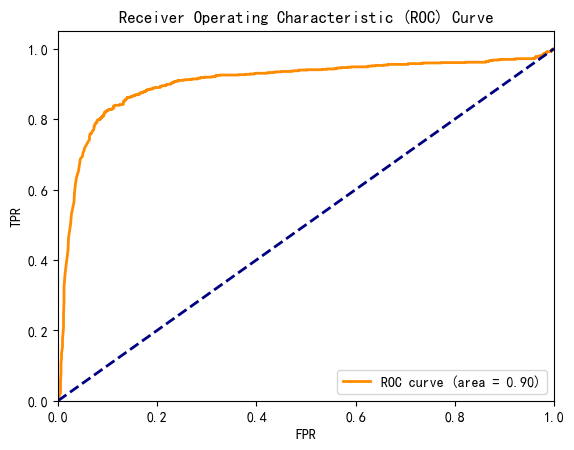

In [19]:
plot_roc("..\model\FN_best.pth", "test.pkl")